# Plot results of the synthetic test case.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import dask
import pandas as pd
import dask.array as da
import xarray as xr
from climate.utils import load_dataset

from dask.distributed import Client, LocalCluster, wait, progress                             
import diesel as ds                                                             
from diesel.scoring import compute_RE_score, compute_CRPS, compute_energy_score, compute_RMSE 
from diesel.estimation import localize_covariance 

In [3]:
# base_folder = "/storage/homefs/ct19x463/Dev/Climate/Data/"
base_folder = "/home/cedric/PHD/Dev/Climate/Data/"

# results_folder = "/storage/homefs/ct19x463/Dev/DIESEL/reporting/toy_example/results_paper/synthetic/"
results_folder = "/home/cedric/PHD/Dev/DIESEL/reporting/paleoclimate/results/twentieth_century/"
plots_folder = "/home/cedric/PHD/Dev/DIESEL/reporting/paleoclimate/results/plots_twentieth_century/"

In [4]:
cluster = LocalCluster()
client = Client(cluster)

/home/cedric/miniconda3/envs/climate/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42815 instead
  warnings.warn(


## Load Data

## Scoring part.

In [7]:
df1 = pd.read_pickle(os.path.join(results_folder, "stations/scores.pkl"))
df2 = pd.read_pickle(os.path.join(results_folder, "stations/scores_90_92.pkl"))

df_scores = pd.concat([df1, df2])

In [8]:
df_scores# df_scores = pd.read_pickle(os.path.join(results_folder, "scores_n200.pkl"))

,date,year,month,RMSE prior,RMSE aao loc,RMSE seq loc,ES prior,ES aao loc,ES seq loc,RE aao loc,RE seq loc
0,1993-01-16,1993,01,1.490715,0.970124,0.892004,125.369878,102.744441,94.303328,0.576488,0.641949
1,1993-02-16,1993,02,1.440801,0.779751,0.835650,123.134884,79.547201,86.720101,0.707110,0.663612
2,1993-03-16,1993,03,1.135214,0.727547,0.709223,97.791047,73.822282,72.332175,0.589260,0.609690
3,1993-04-16,1993,04,0.732535,0.674962,0.685411,67.040415,66.822960,68.639562,0.151010,0.124521
4,1993-05-16,1993,05,0.812693,0.686599,0.671729,69.556893,66.566044,65.453940,0.286238,0.316820
...,...,...,...,...,...,...,...,...,...,...,...
39,1993-04-16,1993,04,0.732535,0.674962,0.685411,67.040415,66.822960,68.639562,0.151010,0.124521
40,1993-05-16,1993,05,0.812693,0.686599,0.671729,69.556893,66.566044,65.453940,0.286238,0.316820
41,1993-06-16,1993,06,0.759690,0.711676,0.715889,65.818308,67.851541,68.978980,0.122408,0.111988
42,1993-07-16,1993,07,0.753351,0.701521,0.682264,65.808476,66.881505,65.334290,0.132866,0.179819


In [9]:
df_melted = pd.melt(df_scores, value_vars=df_scores.columns, var_name="metric", value_name="loss", id_vars=['date', 'year', 'month'])
df_melted['experiment'] = df_melted['metric']

df_melted.loc[df_melted['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted.loc[df_melted['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted.loc[df_melted['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted.loc[df_melted['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted.loc[df_melted['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted.loc[df_melted['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted.loc[df_melted['metric'].str.contains("RE"), 'metric'] = 'RE'

In [7]:
df_melted

,date,year,month,metric,loss,experiment
0,1990-01-16,1990,01,RMSE,1.220801,Prior
1,1990-02-16,1990,02,RMSE,1.766228,Prior
2,1990-03-16,1990,03,RMSE,1.870666,Prior
3,1990-04-16,1990,04,RMSE,1.031782,Prior
4,1990-05-16,1990,05,RMSE,0.912624,Prior
...,...,...,...,...,...,...
347,1993-04-16,1993,04,RE,0.124521,Sequential
348,1993-05-16,1993,05,RE,0.316820,Sequential
349,1993-06-16,1993,06,RE,0.111988,Sequential
350,1993-07-16,1993,07,RE,0.179819,Sequential


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot parameters.
sns.set()                                                                         
sns.set_style("white")                                                            
# plt.rcParams["font.family"] = "Helvetica"                                       
plt.rcParams["font.family"] = ["Arial"]                                           
plot_params = {                                                                   
         'font.size': 25, 'font.style': 'normal',                                  
          'axes.labelsize': 'medium',                                                
          'axes.titlesize':'medium',                                                 
          'legend.fontsize': 'medium',                                               
          'xtick.labelsize': 'medium',                                               
          'ytick.labelsize': 'small',                                               
          }                                                                         
plt.rcParams.update(plot_params)                                                  
plt.rc('xtick', labelsize=22)                                                     
plt.rc('ytick', labelsize=22) 

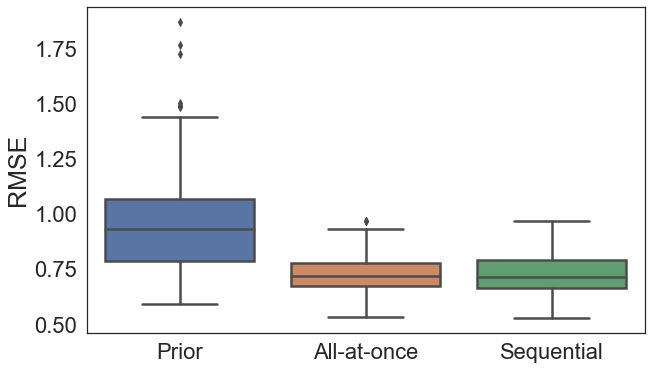

In [11]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted[df_melted['metric'] == 'RMSE'], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RMSE'), bbox_inches='tight', dpi=200)

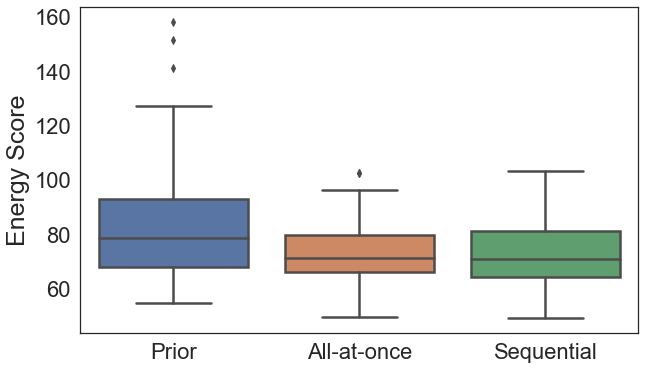

In [12]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted[df_melted['metric'] == 'ES'], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_ES'), bbox_inches='tight', dpi=200)

/home/cedric/miniconda3/envs/climate/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

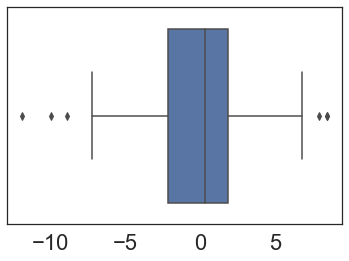

In [17]:
sns.boxplot(df_scores['ES aao loc'] - df_scores['ES seq loc'])

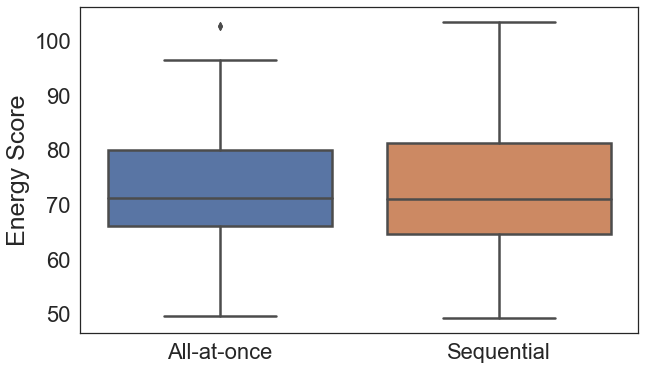

In [15]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_mod.loc[(df_melted_mod['metric'] == 'ES') & (df_melted_mod['experiment'] != 'Prior')], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_ES'), bbox_inches='tight', dpi=200)

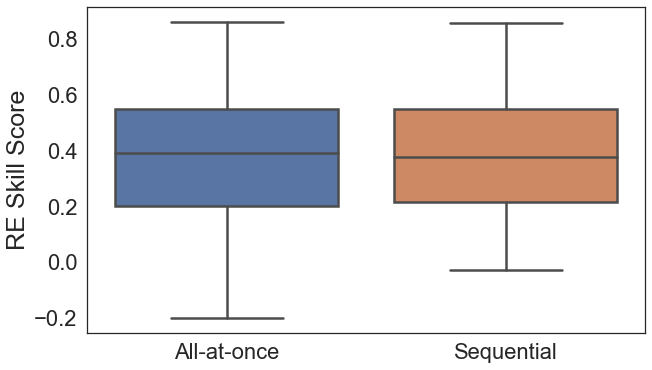

In [14]:
plt.figure(figsize=(10,6))
df_melted_mod = pd.concat([pd.DataFrame({'metric': ['RE'], 'loss': [np.nan], 'experiment': ['Prior']}), df_melted], axis=0)

ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_mod[(df_melted_mod['metric'] == 'RE') & (df_melted_mod['experiment'] != 'Prior')], linewidth=2.5)
ax.set_ylabel('RE Skill Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RE'), bbox_inches='tight', dpi=200)

In [57]:
df_scores_n400 = pd.concat([pd.read_pickle(os.path.join(results_folder, "./scores_n400_old.pkl")),
                            pd.read_pickle(os.path.join(results_folder, "./scores_n400.pkl"))])
df_scores_n400

,date,year,month,RMSE prior,RMSE aao loc,RMSE seq loc,ES prior,ES aao loc,ES seq loc,RE aao loc,RE seq loc
0,1900-01-16,1900,01,4.072870,2.218899,2.287956,201.107451,132.794608,139.352895,0.801855,0.768911
1,1900-02-16,1900,02,4.356488,2.224265,2.334755,219.486049,133.504857,142.603037,0.780472,0.758068
2,1900-03-16,1900,03,7.378017,2.394853,2.446727,408.662806,144.376791,149.430787,0.943569,0.930892
3,1900-04-16,1900,04,13.278823,2.668663,2.841474,804.551645,164.569876,177.290213,0.980758,0.978579
4,1900-05-16,1900,05,19.933140,3.311564,3.347751,1259.810719,208.480669,211.931655,0.987499,0.987270
5,1900-06-16,1900,06,25.684214,5.356536,5.661974,1647.572169,343.479649,364.990463,0.982539,0.980650
6,1900-07-16,1900,07,28.263666,9.745294,9.818236,1819.056318,636.056935,642.068104,0.979258,0.978433
7,1900-08-16,1900,08,26.534758,5.772050,6.182978,1703.554712,371.290869,399.791428,0.982523,0.978493
8,1900-09-16,1900,09,21.458464,3.614388,3.627491,1362.063037,228.636380,230.520579,0.983884,0.983906
9,1900-10-16,1900,10,14.628938,3.225598,3.464002,901.570509,202.687395,219.681741,0.978931,0.973639


In [58]:
df_melted_n400 = pd.melt(df_scores_n400, value_vars=df_scores_n400.columns, var_name="metric", value_name="loss", id_vars=['date', 'year', 'month'])
df_melted_n400['experiment'] = df_melted_n400['metric']

df_melted_n400.loc[df_melted_n400['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted_n400.loc[df_melted_n400['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted_n400.loc[df_melted_n400['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted_n400.loc[df_melted_n400['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted_n400.loc[df_melted_n400['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted_n400.loc[df_melted_n400['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted_n400.loc[df_melted_n400['metric'].str.contains("RE"), 'metric'] = 'RE'

In [12]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n400.loc[
                     (df_melted_n400['metric'] == 'RMSE') & (df_melted_n400['experiment'] != 'Prior')
                    ], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
ax.set_ylim([1, 4])
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_n400'), bbox_inches='tight', dpi=200)

NameError: name 'df_melted_n400' is not defined

<Figure size 720x432 with 0 Axes>

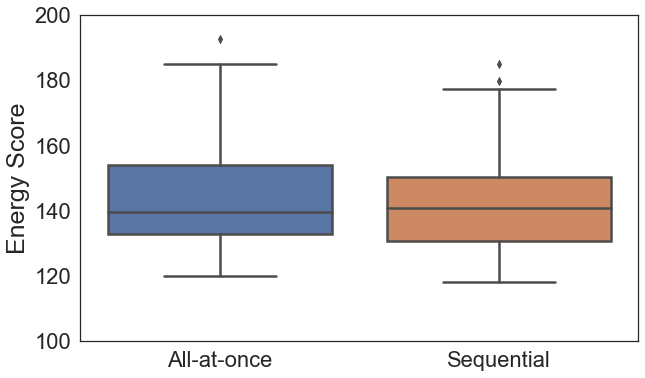

In [60]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n400.loc[
                     (df_melted_n400['metric'] == 'ES') & (df_melted_n400['experiment'] != 'Prior')
                      ], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
ax.set_ylim([100, 200])
plt.savefig(os.path.join(plots_folder, 'scores_ES_n400'), bbox_inches='tight', dpi=200)

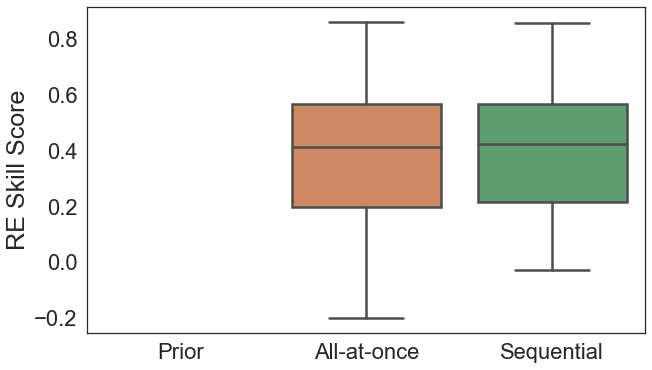

In [13]:
plt.figure(figsize=(10,6))
# df_melted_mod_n400 = pd.concat([pd.DataFrame({'metric': ['RE'], 'loss': [np.nan], 'experiment': ['Prior']}), df_melted_n400], axis=0)

ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_mod[df_melted_mod['metric'] == 'RE'], linewidth=2.5)
ax.set_ylabel('RE Skill Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RE'), bbox_inches='tight', dpi=200)

## Now with 800 datapoints.

In [62]:
df_scores_n800 = pd.read_pickle(os.path.join(results_folder, "./scores_n800_merged.pkl")              

df_melted_n800 = pd.melt(df_scores_n800, value_vars=df_scores_n800.columns, var_name="metric", value_name="loss", id_vars=['date', 'year', 'month'])
df_melted_n800['experiment'] = df_melted_n800['metric']

df_melted_n800.loc[df_melted_n800['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted_n800.loc[df_melted_n800['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("RE"), 'metric'] = 'RE'

SyntaxError: invalid syntax (1251851942.py, line 3)

In [63]:
df_scores_n800

,date,year,month,RMSE prior,RMSE aao loc,RMSE seq loc,ES prior,ES aao loc,ES seq loc,RE aao loc,RE seq loc
0,1900-01-16,1900,01,4.072870,2.148771,2.136245,201.107451,135.002890,135.422026,0.840116,0.810966
1,1900-02-16,1900,02,4.356488,2.069796,2.117424,219.486049,129.832976,134.103264,0.858752,0.824028
2,1900-03-16,1900,03,7.378017,2.019717,2.101560,408.662806,126.888561,133.392750,0.965777,0.957647
3,1900-04-16,1900,04,13.278823,2.258430,2.163476,804.551645,143.568548,138.022811,0.990426,0.987979
4,1900-05-16,1900,05,19.933140,2.679108,2.879980,1259.810719,171.727955,185.808278,0.994493,0.992915
5,1900-06-16,1900,06,25.684214,4.370311,4.470266,1647.572169,284.001156,291.404928,0.993282,0.989328
6,1900-07-16,1900,07,28.263666,5.947060,5.910398,1819.056318,388.537974,386.851861,0.990992,0.987410
7,1900-08-16,1900,08,26.534758,3.853566,4.292971,1703.554712,249.805929,279.786724,0.993669,0.989844
8,1900-09-16,1900,09,21.458464,2.826787,3.105357,1362.063037,181.326626,200.573817,0.993678,0.990748
9,1900-10-16,1900,10,14.628938,2.674031,2.650013,901.570509,171.447932,170.606005,0.990250,0.986141


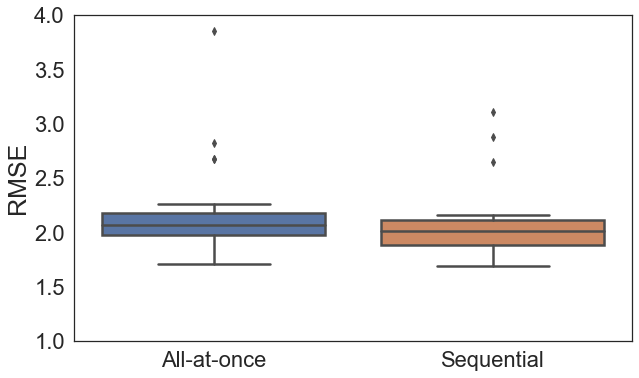

In [64]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'RMSE') & (df_melted_n800['experiment'] != 'Prior')
                    ], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
ax.set_ylim([1, 4])
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_n800'), bbox_inches='tight', dpi=200)

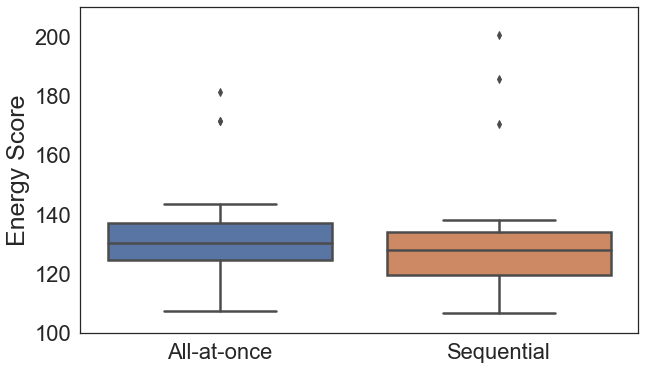

In [65]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'ES') & (df_melted_n800['experiment'] != 'Prior')
                      ], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
ax.set_ylim([100, 210])
plt.savefig(os.path.join(plots_folder, 'scores_ES_n800'), bbox_inches='tight', dpi=200)

## Plot 1200

In [67]:
df_scores_n1200 = pd.read_pickle(os.path.join(results_folder, "./scores_n1200_merged.pkl"))           

df_melted_n1200 = pd.melt(df_scores_n1200, value_vars=df_scores_n1200.columns, var_name="metric", value_name="loss", id_vars=['date', 'year', 'month'])
df_melted_n1200['experiment'] = df_melted_n1200['metric']

df_melted_n1200.loc[df_melted_n1200['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted_n1200.loc[df_melted_n1200['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted_n1200.loc[df_melted_n1200['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted_n1200.loc[df_melted_n1200['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted_n1200.loc[df_melted_n1200['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted_n1200.loc[df_melted_n1200['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted_n1200.loc[df_melted_n1200['metric'].str.contains("RE"), 'metric'] = 'RE'

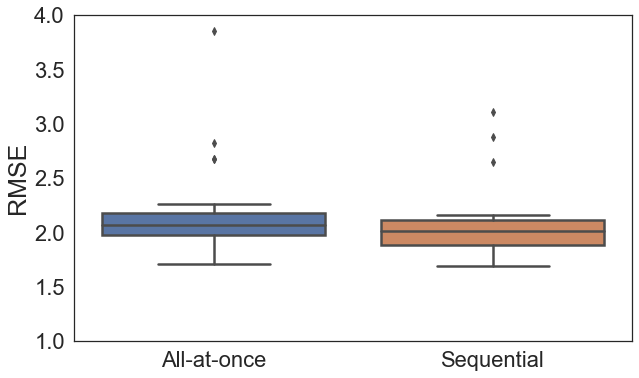

In [68]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'RMSE') & (df_melted_n800['experiment'] != 'Prior')
                    ], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
ax.set_ylim([1, 4])
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_n800'), bbox_inches='tight', dpi=200)

## Plot Well Spec.

In [85]:
df_scores_n800 = pd.read_pickle(os.path.join(results_folder, "scores_n1200_wellspec.pkl"))             

df_melted_n800 = pd.melt(df_scores_n800, value_vars=df_scores_n800.columns, var_name="metric", value_name="loss", id_vars=['date', 'year', 'month'])
df_melted_n800['experiment'] = df_melted_n800['metric']

df_melted_n800.loc[df_melted_n800['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted_n800.loc[df_melted_n800['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("RE"), 'metric'] = 'RE'

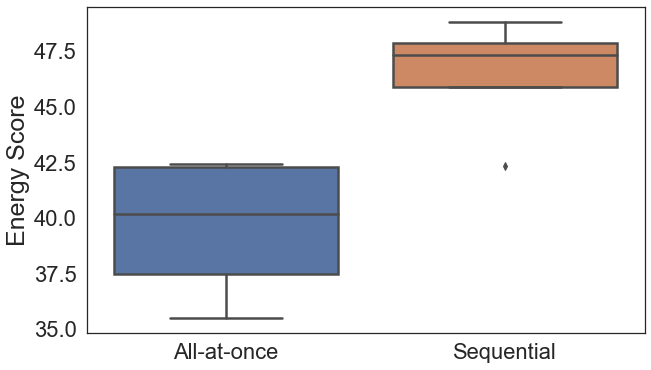

In [86]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'ES') & (df_melted_n800['experiment'] != 'Prior')
                      ], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
# ax.set_ylim([100, 210])
plt.savefig(os.path.join(plots_folder, 'scores_ES_wellspec'), bbox_inches='tight', dpi=200)

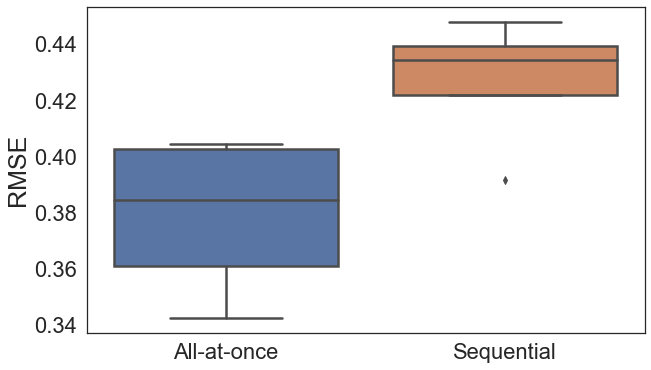

In [87]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'RMSE') & (df_melted_n800['experiment'] != 'Prior')
                    ], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
# ax.set_ylim([1, 4])
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_wellspec'), bbox_inches='tight', dpi=200)

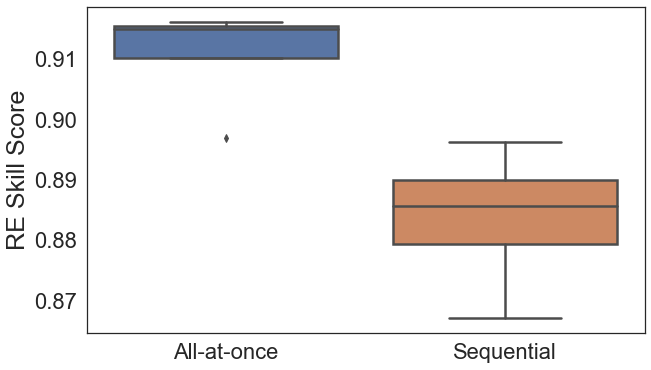

In [88]:
plt.figure(figsize=(10,6))
# df_melted_mod_n400 = pd.concat([pd.DataFrame({'metric': ['RE'], 'loss': [np.nan], 'experiment': ['Prior']}), df_melted_n400], axis=0)

ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800[df_melted_n800['metric'] == 'RE'], linewidth=2.5)
ax.set_ylabel('RE Skill Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RE_wellspec'), bbox_inches='tight', dpi=200)

## Ordering

In [11]:
df_scores_n800 = pd.read_pickle(os.path.join(results_folder, "synthetic_ordering/scores.pkl"))             

df_melted_n800 = pd.melt(df_scores_n800, value_vars=df_scores_n800.columns, var_name="metric", value_name="loss",)
df_melted_n800['experiment'] = df_melted_n800['metric']

df_melted_n800.loc[df_melted_n800['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted_n800.loc[df_melted_n800['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted_n800.loc[df_melted_n800['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted_n800.loc[df_melted_n800['metric'].str.contains("RE"), 'metric'] = 'RE'

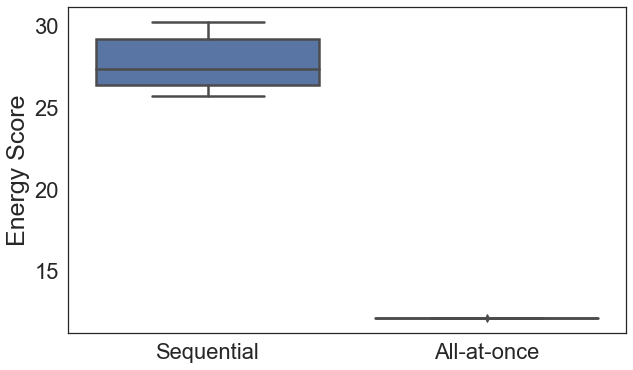

In [12]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'ES') & (df_melted_n800['experiment'] != 'Prior')
                      ], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
# ax.set_ylim([100, 210])
plt.savefig(os.path.join(plots_folder, 'scores_ES_ordering'), bbox_inches='tight', dpi=200)

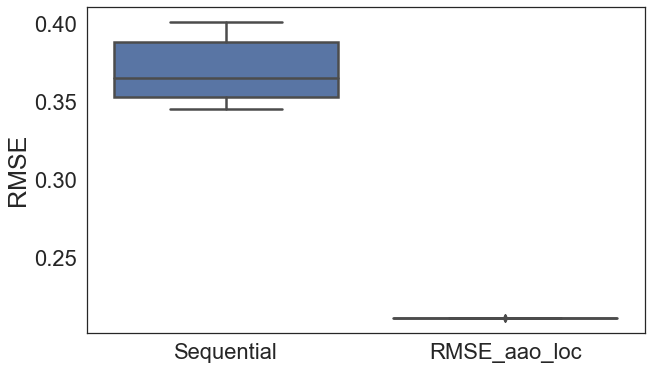

In [13]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800.loc[
                     (df_melted_n800['metric'] == 'RMSE') & (df_melted_n800['experiment'] != 'Prior')
                    ], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
# ax.set_ylim([1, 4])
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_ordering'), bbox_inches='tight', dpi=200)

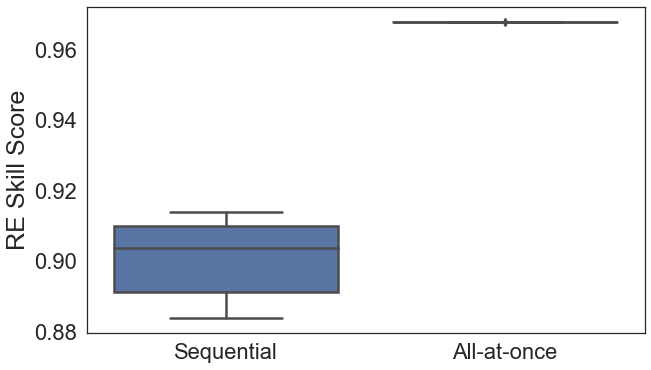

In [14]:
plt.figure(figsize=(10,6))
# df_melted_mod_n400 = pd.concat([pd.DataFrame({'metric': ['RE'], 'loss': [np.nan], 'experiment': ['Prior']}), df_melted_n400], axis=0)

ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_n800[df_melted_n800['metric'] == 'RE'], linewidth=2.5)
ax.set_ylabel('RE Skill Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RE_ordering'), bbox_inches='tight', dpi=200)

## Plot spatially

In [36]:
TOT_ENSEMBLES_NUMBER = 30
(dataset_mean, dataset_members,
    dataset_instrumental, dataset_reference,
    dataset_members_zarr)= load_dataset(
    base_folder, TOT_ENSEMBLES_NUMBER, ignore_members=True)
print("Loading done.")

/home/cedric/PHD/Dev/Climate/climate/utils.py:144: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_mean['time'] = dataset_mean.indexes['time'].to_datetimeindex()
/home/cedric/PHD/Dev/Climate/climate/utils.py:145: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_members['time'] = dataset_members.indexes['time'].to_datetimeindex()


Loading done.


In [40]:
from climate.kalman_filter import EnsembleKalmanFilterScatter
helper_filter = EnsembleKalmanFilterScatter(dataset_mean, dataset_members_zarr, dataset_instrumental, client)

# Prepare vectors.
year, month = '1901', '05'
assimilation_date = '{}-{}-16'.format(year, month)
mean_ds = helper_filter.dataset_mean.get_window_vector(assimilation_date, assimilation_date, variable='temperature')
ensemble_ds = helper_filter.dataset_members.get_window_vector(assimilation_date, assimilation_date, variable='temperature')

Maximal distance to matched point: 120.54565778878536 km.


ValueError: Date not found.

In [15]:
df_scores_n800

,RMSE prior,RMSE seq loc,RMSE_aao_loc,ES prior,ES seq loc,ES aao loc,RE seq loc,RE aao loc
0,1.177776,0.345828,0.210979,67.604115,25.771172,12.119154,0.913783,0.967911
1,1.177776,0.401566,0.210979,67.604115,30.264113,12.119154,0.883751,0.967911
2,1.177776,0.355798,0.210979,67.604115,26.592820,12.119154,0.908740,0.967911
3,1.177776,0.390343,0.210979,67.604115,29.349824,12.119154,0.890158,0.967911
4,1.177776,0.361817,0.210979,67.604115,27.083577,12.119154,0.905626,0.967911
5,1.177776,0.345534,0.210979,67.604115,25.745799,12.119154,0.913929,0.967911
6,1.177776,0.352605,0.210979,67.604115,26.345756,12.119154,0.910370,0.967911
7,1.177776,0.368696,0.210979,67.604115,27.628404,12.119154,0.902003,0.967911
8,1.177776,0.396600,0.210979,67.604115,29.836519,12.119154,0.886609,0.967911
9,1.177776,0.382267,0.210979,67.604115,28.717119,12.119154,0.894656,0.967911
